In [24]:
words = open('names.txt', 'r').read().splitlines()

In [25]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [26]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [27]:
sorted(b.items(), key = lambda kv: kv[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [28]:
import torch

In [29]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [30]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}



In [31]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

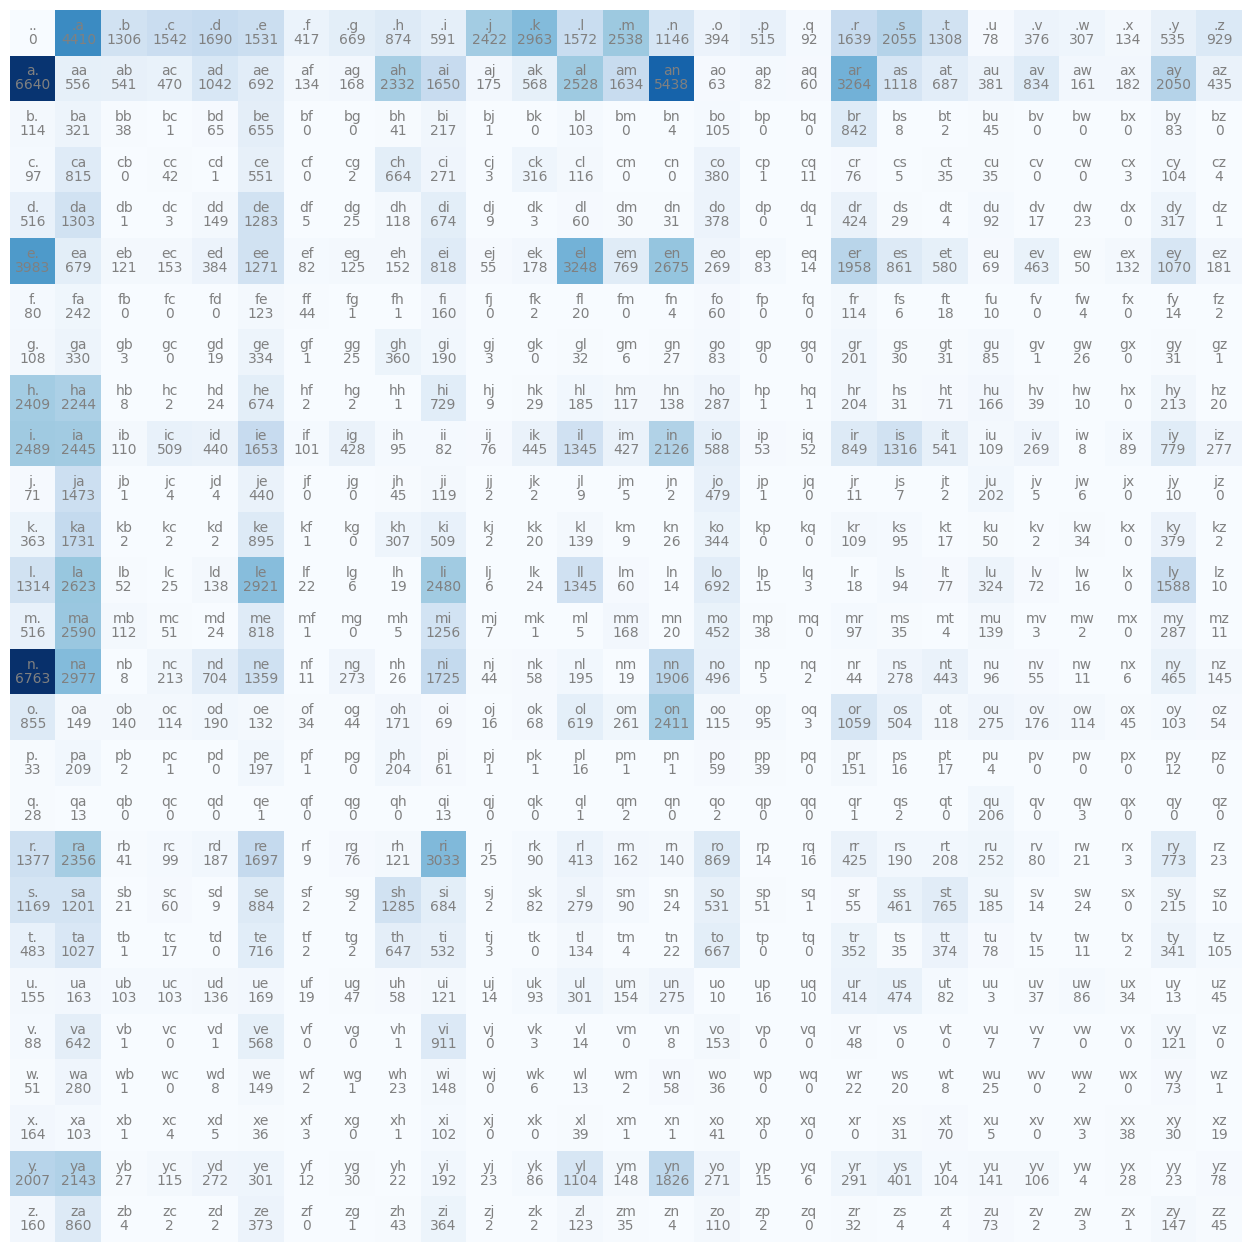

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [52]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [51]:
p = N[0].float()
p = p / p.sum()

In [53]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [41]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p



tensor([0.6064, 0.3033, 0.0903])

In [42]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [72]:
P = (N+1).float() # add 1 for model smoothing, so that we don't get 0 probabilities
P /= P.sum(1 , keepdim=True) # broadcastable because each is 1 or equal, torch will copy it 27 times to make it the same shape as P and do elementwise division

In [73]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0 
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break 
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [74]:
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
    
print(f'{log_likelihood=}')
nll = -log_likelihood # negative log likelihood, lowest it can get is 0
print(f'{nll=}')
print(f'{nll/n=}') # this is used as the loss function in the training loop

# with log log(a*b*c) = log(a) + log(b) + log(c)
# so log_likelihood = log(P(a,b)) + log(P(b,c)) + log(P(c,d)) + ...
# nll = -log_likelihood = -log(P(a,b)) - log(P(b,c)) - log(P(c,d)) - ...
# so nll is the sum of the negative log probabilities of the bigrams in the sentence


.e: 0.0478 -3.0410
em: 0.0377 -3.2793
mm: 0.0253 -3.6753
ma: 0.3885 -0.9454
a.: 0.1958 -1.6305
.o: 0.0123 -4.3965
ol: 0.0779 -2.5526
li: 0.1774 -1.7293
iv: 0.0152 -4.1845
vi: 0.3508 -1.0476
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
av: 0.0246 -3.7041
va: 0.2473 -1.3971
a.: 0.1958 -1.6305
.i: 0.0185 -3.9919
is: 0.0743 -2.5998
sa: 0.1478 -1.9119
ab: 0.0160 -4.1363
be: 0.2455 -1.4044
el: 0.1589 -1.8396
ll: 0.0962 -2.3408
la: 0.1876 -1.6733
a.: 0.1958 -1.6305
.s: 0.0641 -2.7468
so: 0.0654 -2.7270
op: 0.0121 -4.4180
ph: 0.1947 -1.6364
hi: 0.0955 -2.3485
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.c: 0.0481 -3.0339
ch: 0.1869 -1.6774
ha: 0.2937 -1.2251
ar: 0.0963 -2.3405
rl: 0.0325 -3.4256
lo: 0.0496 -3.0047
ot: 0.0149 -4.2032
tt: 0.0670 -2.7031
te: 0.1281 -2.0549
e.: 0.1948 -1.6357
.m: 0.0792 -2.5358
mi: 0.1885 -1.6687
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
am: 0.0482 -3.0321
me: 0.1228 -2.0971
el: 0.1589 -1.8396
li: 0.1774 -1.7293
ia: 0.1380 -1.9807
a.: 0.1958 -

In [75]:
# create the training set of all the bigrams

xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys



. e
e m
m m
m a
a .


(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [82]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() 
xenc


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [83]:
xenc.shape

torch.Size([5, 27])

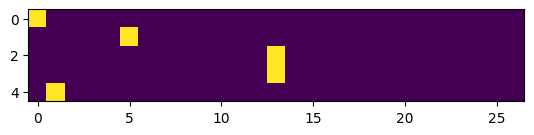

In [84]:
plt.imshow(xenc)

In [85]:
xenc.dtype



torch.float32

In [90]:
# W = torch.randn((27, 1))
# xenc @ W # (5, 27) @ (27, 1) = (5, 1), this operator is called matrix multiplication (W * X no bias)

# instead lets use
W = torch.randn((27, 27))
xenc @ W # (5, 27) @ (27, 27) = (5, 27)

tensor([[ 0.6078, -0.7108,  0.3484, -0.5578, -2.2172,  0.5198,  0.6804, -1.5317,
          0.6957, -1.6608,  2.2638,  1.7286,  0.2987, -1.0345,  0.3527,  0.1078,
          1.6416,  1.2094, -0.7054, -1.5306, -0.5401,  0.1713,  1.0385,  1.0082,
          1.1161, -0.1712, -0.5821],
        [ 0.0460,  0.0978,  1.1801,  3.8482,  1.7163,  0.2526,  1.6345, -0.5312,
         -0.4361, -0.7569, -0.0167,  1.5856, -0.2736,  0.6125,  0.5839, -1.0988,
         -1.0236,  0.7869, -0.2177,  0.8945, -0.3522, -0.6373, -0.4978,  0.5843,
         -0.3733, -2.4261,  0.9359],
        [ 0.5798,  0.7107, -0.5736,  1.7945, -0.1697, -0.4032, -0.0780,  0.1068,
          1.7313,  0.7919,  0.4447, -0.7166,  1.3077, -1.3255, -1.2222, -0.8126,
         -0.8932, -1.4831, -1.6727, -0.9848, -0.9326,  0.3753, -0.6257,  0.8477,
          1.9420,  0.0451,  0.6099],
        [ 0.5798,  0.7107, -0.5736,  1.7945, -0.1697, -0.4032, -0.0780,  0.1068,
          1.7313,  0.7919,  0.4447, -0.7166,  1.3077, -1.3255, -1.2222, -0.8126

In [96]:
logits = xenc @ W # (5, 27) @ (27, 27) = (5, 27)
counts = logits.exp() # using the exp function to get counts
probs = counts / counts.sum(1, keepdim=True) # these 2 lines are the same as the softmax function

 


torch.Size([5, 27])

In [97]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())


--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0360, 0.0096, 0.0278, 0.0112, 0.0021, 0.0330, 0.0387, 0.0042, 0.0393,
        0.0037, 0.1886, 0.1104, 0.0264, 0.0070, 0.0279, 0.0218, 0.1012, 0.0657,
        0.0097, 0.0042, 0.0114, 0.0233, 0.0554, 0.0537, 0.0599, 0.0165, 0.0110])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.032973241060972214
log likelihood: -3.4120588302612305
negative log likelihood: 3.4120588302612305
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0117, 0.0123, 0.0364, 0.5249, 0.0623, 0.0144, 0.0574, 0.0066, 0.0072,
        0.0052, 0.0110, 0.0546, 0.0085, 0.0206, 0.0201, 0.0037, 0.0040, 0.0246,
        0.0090, 0.0274, 0.0079, 0.0059, 0.0068, 0.0201, 0.0077, 0.0010, 0.0285])
label (actual next character): 13
probability assigned by the net to the the correct character:

In [98]:
xs


tensor([ 0,  5, 13, 13,  1])

In [99]:
ys

tensor([ 5, 13, 13,  1,  0])

In [100]:

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [107]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean() # vectorized version of the loss function

In [108]:
print(loss.item())

3.7492129802703857


In [103]:
W.grad = None # clear the gradient
loss.backward() # compute the gradient

In [104]:
W.data += -0.1 * W.grad

In [109]:
# Actual Optimization

In [110]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [115]:
# gradient descent
for k in range(50):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.507380247116089
2.5066258907318115
2.5059032440185547
2.5052106380462646
2.5045459270477295
2.503908157348633
2.503295660018921
2.502706289291382
2.5021398067474365
2.501594305038452
2.5010693073272705
2.500562906265259
2.500075578689575
2.4996049404144287
2.499150514602661
2.4987120628356934
2.498288154602051
2.4978787899017334
2.497483015060425
2.4970998764038086
2.4967293739318848
2.496370315551758
2.496022939682007
2.4956860542297363
2.4953596591949463
2.4950432777404785
2.4947361946105957
2.494438648223877
2.494149684906006
2.4938690662384033
2.4935967922210693
2.4933321475982666
2.493074893951416
2.4928252696990967
2.492582321166992
2.4923462867736816
2.492116689682007
2.4918932914733887
2.491675853729248
2.491464376449585
2.4912586212158203
2.491058111190796
2.4908626079559326
2.4906723499298096
2.4904870986938477
2.4903063774108887
2.4901304244995117
2.4899587631225586
2.4897916316986084
2.489628314971924


In [ ]:
# This approach is called stochastic gradient descent and is much more flexible than the counter based approach while achieving the same result

In [116]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))


junide.
janasah.
p.
cfay.
a.
